In [3]:
from sources import *
from analysis import * 
from datetime import datetime as dt

/Users/nicholasjenkins/downloads/ENTER/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:

def generate_auction_activity(verbose=False, test=False):
    """ Generates auction history parquet file with auctions of interest.
        Reads and parses Beancounter auction history across all characters
        Works the data into a labelled and cleaned pandas before parquet saves
    """
    relevant_auction_types = ['failedAuctions', 'completedAuctions', 'completedBidsBuyouts']       

    settings = get_general_settings()
    data = read_lua('BeanCounter')

    # Generates BeanCounters id:item_name dict
    num_item = {}
    for key, item_raw in data['BeanCounterDBNames'].items():
        item_name = item_raw.split(";")[1]
        num_item[key.split(":")[0]] = item_name

    # Parses all characters relevant listings into flat list
    parsed = []
    for character, auction_data in data['BeanCounterDB']['Grobbulus'].items():
        for auction_type, item_listings in auction_data.items():
            if auction_type in relevant_auction_types: 
                auction_name = settings['auction_type_labels'][auction_type]      
                for item_id, listings in item_listings.items():            
                    for _, listing in listings.items():
                        for auction in listing:
                            parsed.append([auction_name] + [num_item[item_id]] + [character] + auction.split(';'))

    # Setup as pandas dataframe, remove irrelevant columns
    df = pd.DataFrame(parsed)
    df = df.drop([4,5,6,8,11,12], axis=1)

    cols = ["auction_type", "item", "character", "count", "price", "agent", "timestamp"]
    df.rename(columns=dict(zip(df.columns, cols)), inplace=True)

    df = df[df['price']!='']
    df['price'] = df['price'].astype(int)
    df['count'] = df['count'].astype(int)

    df['price_per'] = round(df['price'] / df['count'], 4)
    df['timestamp'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(int(x)))

    return df
    
#     if test: return None # avoid saves
#     if verbose: 
#         print(f"Auction actions full repository. {df.shape[0]} records")
#     df.to_parquet('full/auction_activity.parquet', compression='gzip')

In [5]:
df = generate_auction_activity()

In [8]:
df['auction_type'].value_counts()

buy_price     14679
sell_price    13741
failed         3954
Name: auction_type, dtype: int64

In [17]:
df = df.set_index('timestamp').sort_index()

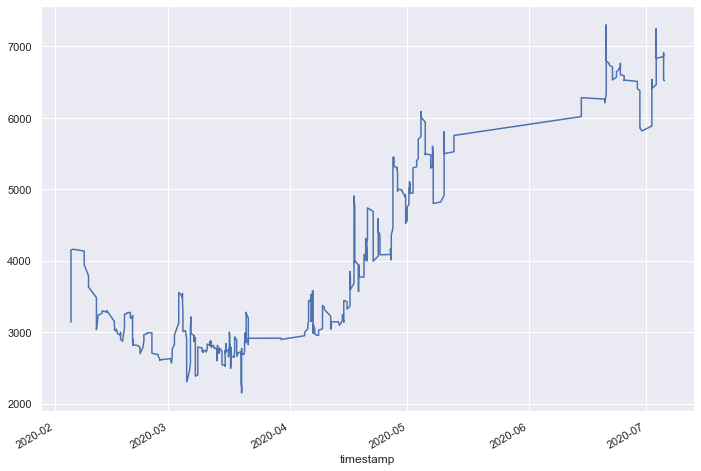

In [29]:
df[df['item']=='Gromsblood']['price_per'].rolling(10).mean().plot()

In [30]:
def analyse_item_prices(verbose=False, full_pricing=False, test=False):
    """
    Generate item prices based on all past auction activity and scans
    """

    auction_activity = pd.read_parquet('full/auction_activity.parquet')
    auction_activity = auction_activity[['item', 'timestamp', 'price_per', 'auction_type']]

    auction_scan_minprice = pd.read_parquet('full/auction_scan_minprice.parquet')

    df_auction_prices = auction_scan_minprice.append(auction_activity)

    if full_pricing:
        items = df_auction_prices['iten'].unique()
    else:
        items = load_items()

    price_history = df_auction_prices.set_index(['item', 'timestamp']).sort_index()['price_per']

    if full_pricing:
        item_prices = {item: price_history.loc[item].ewm(alpha=0.2).mean().iloc[-1] for item in items}    
    else:
        # Only calculate for our item list; get backup price if present
        item_prices = {}
        for item, details in items.items():
            price = details.get('backup_price')
            if not price:
                price = price_history.loc[item].ewm(alpha=0.2).mean().iloc[-1]
            item_prices[item] = price
    
    item_prices = pd.DataFrame.from_dict(item_prices, orient='index')
    item_prices.index.name = 'item'
    item_prices.columns = ['market_price']

    return item_prices

In [31]:
item_prices = analyse_item_prices()

In [ ]:
#4.31 seconds save time (4/26)
start = dt.now()
print(start)

generate_auction_scandata(verbose=True)
generate_auction_activity(verbose=True)
generate_inventory(verbose=True)
analyse_item_prices(verbose=True)
analyse_sales_performance()
analyse_item_min_sell_price()
analyse_sell_data()
apply_buy_policy(additional_percent=1.01)

end = dt.now()
print(end)
print("Time taken", (end - start).total_seconds())
